<font size = "5"> **Day 1: [Atomic Resolution STEM and Machine Learning](../MLSTEM2025.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />



[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Imaging/3_Probe.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Imaging/3_Probe.ipynb)


# Probe

part of the workshop of 

<font size = "5"> **[Machine Learning in Transmission Electron Microscopy](../_MLSTEM.ipynb)**</font>


**Day1: Atomic Resolution STEM,**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
    <td></td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**May 2025**


## Load packages
### Check for Newest Versions

In [ ]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.2.3':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q

print('done')

### Load Necessary Packages

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%load_ext autoreload
%autoreload 2
    
sys.path.insert(0,'..//..//pyTEMlib//')

if 'google.colab' in sys.modules:
    from google.colab import output
    from google.colab import drive
    output.enable_custom_widget_manager()
    
from matplotlib.patches import Circle

import pyTEMlib
import pyTEMlib.probe_tools

print('pyTEM version: ', pyTEMlib.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pyTEM version:  0.2025.04.0


### Aberration Function $\chi$

Please see this notebook for a more detailed discussion of the [Aberration Function](CH3_03-CTF.ipynb#Aberrations)

With the main aberration coefficients $C_{n,m}$:

Coefficient  Nion | CEOS | Name
 ----------------|------------- | -------------
 $C_{10}$ | $C_1$ |defocus
 $C_{12a}$, $C_{12b}$  | $A_1$ |astigmatism
 $C_{21a}$, $C_{21b}$  | $B_2$ |coma
 $C_{23a}$, $C_{23b}$  | $A_2$ |three-fold astigmatism
 $C_{30}$  | $C_3$ |spherical aberration
    
As before the aberration function $\chi$ in polar coordinates (of angles) $\theta$ and $\phi$ is defined according to [Krivanek et al.](https://doi.org/10.1016/S0304-3991(99)00013-3):

$$
\chi(\theta, \phi) = \sum_n \theta^{n+1} *\frac{1}{n+1} * \sum_{n} C_{n,m,a}  \cos(m*\phi) + C_{n,m,b} \sin(m*\phi) 
$$

with:
- $n$: order ($n=0,1,2,3,...$)
- $m$: symmetry  $m = ..., n+1$;  
    - $m$ is all odd   for n = even
    - $m$ is all even  for n = odd

    

In the following we program the equation above just as seen. The terms are divided into the theta (line 22) and the sum part (line 33).  The product of these two terms is summed in line 39.

We assume that the aberrations are given up to fifth order.




We see that increasing the size of an coherently illuminated aperture is reducing the probe diameter and therefore improving spatial resolution. The goal is to obtain an as large radius as possible of quasi-coherent area (in reciprocal space) match it with an aperture and use that as a probforming configuration.

The Ronchigram will get us that coherent illumination and we will discuss this Ronchigram in detail in this notebook.

## Calculate Ronchigram

Setting up the meshes of angles $\phi$ and $\theta$ in polar coordinates for which the aberrations will be calculated.
This is analog to what we did in the [Aberration Function notebook](./CH3_03-CTF.ipynb#Aberrations).


The effect of defocus $C_{10}$ and astigmatism $C_{12a}$ and $C_{12b}$ on the ronchigram can be explored below.
Also change coma $C_{21a}$ and $C_{21b}$ and spherical aberration  $C_{30}$ or anyother aberration you might want to test.

### Load Aberrations

The aberrations are expected to be in a python dictionary.

Besides the aberration coefficients, 
for the calculation of the aberrations the wavelength and therefore the acceleration voltage is needed.

Here we load the aberration for a microscope: the following microscpes are available:
- ZeissMC200
- NionUS200
- NionUS100

In [5]:

ab = pyTEMlib.probe_tools.get_target_aberrations("ZeissMC200",200000)
ab = pyTEMlib.probe_tools.get_target_aberrations("NionUS200",200000)
#ab = pyTEMlib.probe_tools.get_target_aberrations("NionUS100",60000)
ab = pyTEMlib.probe_tools.get_target_aberrations("Spectra300", 200000)
ab['C10'] = -5
reciprocal_FOV = ab['reciprocal_FOV'] = 150*1e-3
ab['FOV'] = 1/reciprocal_FOV
ab['extent'] = [-reciprocal_FOV*1000,reciprocal_FOV*1000,-reciprocal_FOV*1000,reciprocal_FOV*1000]
ab['size'] = 512
ab['wavelength'] = pyTEMlib.probe_tools.get_wavelength(ab['acceleration_voltage'])

pyTEMlib.probe_tools.print_aberrations(ab)

 **** Using Target Values at 200.0kV for Aberrations of NionUS200****


### Probe Shape Calculation
The probe shape is defined as the absolute of the 
inverse of the aberration function which is limited by an aperture.



In [6]:
ab.update({'A1': [-1.7256467648864592e-09, -4.33652950047942e-09],
  'A2': [1.1832002758281756e-07, -9.356132757317088e-08],
  'C3': [3.9123259711154475e-07, 0.0],
  'C1': [-7.160069847952156e-09, 0.0],
  'A4': [-1.2421582380458277e-06, -6.555555994007509e-07],
  'A3': [9.14858860850468e-08, 8.24581795110536e-08],
  'A5': [2.4305034548402935e-05, -4.3665588715379156e-05],
  'B2': [-3.583665699539742e-08, -7.368501963663006e-08],
  'B4': [2.7117076219729385e-07, 3.745259044319655e-06],
  'S3': [1.892912397258682e-07, -5.2074838081861786e-08],
  'C5': [-1.4203666265095235e-05, 0.0],
  'D4': [-1.0812219869916382e-07, 4.316301635786145e-06],
  'WD': [0.000120721584514962, 2.8815317878038834e-05]},)





0.03
0.03


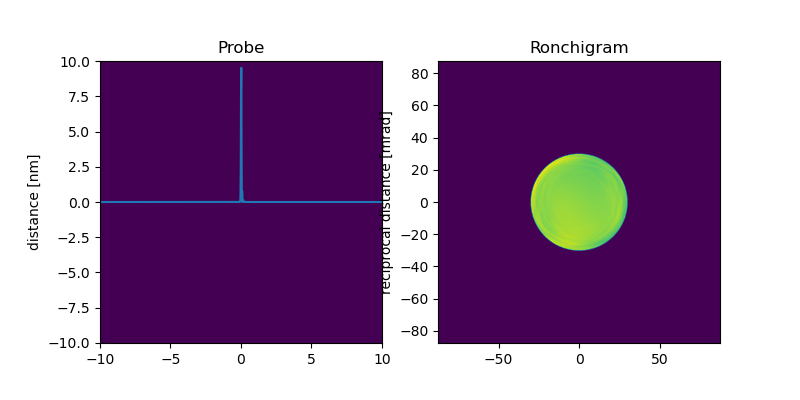

In [7]:
sizeX = 512*2
probe_FOV  = 20
ab['Cc'] = 1
ab['C10'] = 0

ronchi_FOV = 350 #mrad
condensor_aperture_radius =  30  # mrad
ronchi_condensor_aperture_radius = 30  # mrad
ab['FOV'] = probe_FOV
ab['convergence_angle'] = condensor_aperture_radius
probe, A_k, chi  = pyTEMlib.probe_tools.get_probe( ab, sizeX, sizeX,  scale = 'mrad', verbose= True)

ab['FOV'] = 4/ronchi_FOV*sizeX/2 * ab['wavelength'] *1000
ab['convergence_angle'] = ronchi_condensor_aperture_radius ## let have a little bit of a view
ronchigram = pyTEMlib.probe_tools.get_ronchigram(1024, ab, scale = 'mrad'  )

ab['FOV'] = probe_FOV
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(probe, extent = [-int(ab['FOV']/2),int(ab['FOV']/2),-int(ab['FOV']/2),int(ab['FOV']/2)])
ax[0].set_ylabel('distance [nm]')
profile = probe[:, 256]
ax[0].plot(np.linspace(-ab['FOV']/2,ab['FOV']/2,profile.shape[0]), probe[int(probe.shape[1]/2),:]/probe[int(probe.shape[1]/2),:].max()*probe_FOV/2.1)
ax[0].set_title('Probe')
ax[1].imshow(ronchigram, extent = ab['ronchi_extent'])
ax[1].set_ylabel(ab['ronchi_label'])
ax[1].set_title('Ronchigram')
pyTEMlib.probe_tools.print_aberrations_polar(ab)
    
    
#condensor_aperture = Circle((0, 0), radius = condensor_aperture_radius)#, fill = False, color = 'red')
#plt.gca().add_patch(condensor_aperture);

In [8]:
def get_probe_large(ab):    
    ab['FOV'] = 20
    sizeX = 512*2
    probe, A_k, chi  = pyTEMlib.probe_tools.get_probe( ab, sizeX, sizeX,  scale = 'mrad', verbose= True)
    
    res = np.zeros((512, 512))
    res[256-32:256+32, 256-32:256+32 ] = skimage.transform.resize(probe, (64, 64))
    
    return res


from skimage.draw import random_shapes

def get_large_image(number_of_electrons=1000):
    image, _ = random_shapes((512, 512), min_shapes=15, max_shapes=26, shape='circle',
                             min_size=40, max_size = 60, allow_overlap=False, num_channels=1)
    image = 1-np.squeeze(image)/image.max()
    image[image<.1] = 0
    image[image>0] = number_of_electrons
    noise = np.random.poisson(image)
    image = image+noise+np.random.random(image.shape)*noise.max()
    return image
     

def large_image (ab, image=None, FOV=15*4) :
    
    out = np.zeros([3, image.shape[0], image.shape[1]])

    C10 = ab['C10'] 
    
    
    ab['C10'] = C10-180
    res = get_probe_large(ab)
    out[1] = scipy.signal.fftconvolve(image, res, mode='same') 

    ab['C10'] = C10+180
    res = get_probe_large(ab)
    out[2] = scipy.signal.fftconvolve(image, res, mode='same') 

    ab['C10'] = C10
    res = get_probe_large(ab)
    out[0] = scipy.signal.fftconvolve(image, res, mode='same') 
    
    return out, res
ab['C10'] = 30
ab['C23b'] = 400
ab['C23a'] = -200

ab['C21a'] = -400
ab['C21b'] = -00

image = get_large_image(number_of_electrons=10)

imaged, res = large_image(ab, image, 90)
image *= 1000/image.max()

fig, axs = plt.subplots(1, 4, layout='constrained', figsize=(10, 4))

axs[0].imshow(imaged[0], cmap='gray')
axs[1].imshow(imaged[1], cmap='gray')
axs[2].imshow(imaged[2], cmap='gray')
axs[3].imshow(res)
axs[3].set_ylim(256-30,256+30)
axs[3].set_xlim(256-30,256+30)


0.03


NameError: name 'skimage' is not defined

In [ ]:
def get_probe_shape_from_images(images):
    im1 = np.fft.fft2(np.array(images[0]))
    im2 = np.fft.fft2(np.array(images[1]))
    im3 = np.fft.fft2(np.array(images[2]))
    g1 = np.fft.fft2(probe_tools.make_gauss(512,512,3))

    dec = np.zeros([2, im1.shape[0], im1.shape[1]])
    dec[0] = np.fft.ifft2(g1*(im2/im1).T)
    dec[1] = np.fft.ifft2(g1*(im3/im1).T)

    return dec

dec = get_probe_shape_from_images(imaged)
plt.figure()
plt.subplot(211)
plt.imshow(dec[0].real.T, vmin = dec.real.max()/8)
plt.ylim(256-30,256+30)
plt.xlim(256-30,256+30)
plt.subplot(221)
plt.imshow(dec[1].real, vmin = 0)# dec.real.max()/8)
plt.ylim(256-30,256+30)
plt.xlim(256-30,256+30)



pyTEMlib.probe_tools.print_aberrations(ab)

In [ ]:
from ase import build 

ab['C10'] = -0
ab['C23b'] = 0
ab['C23a'] = -0

ab['C21a'] = -0
ab['C12b'] = -0
ab['FOV'] = 20

def atomic_image(ab):
    sizeX = 512*2
    
    FOV = ab['FOV']*10*2
    
    print('FOV:', FOV)
    slab = build.fcc100('Al', size=(2, 2, 1), orthogonal=True)
    slab *= (int(FOV/slab.cell[0,0]+1), int(FOV/slab.cell[1,1]+1), 1)
    slab.center()
    slab.positions, slab.cell[0,0]
    ab['FOV'] = slab.cell[0,0]/10
    FOV = slab.cell[0,0]
    print(FOV)
    
    probe, A_k, chi  = pyTEMlib.probe_tools.get_probe( ab, sizeX, sizeX,  scale = 'mrad', verbose= True)
    
    pos = np.int32(slab.positions[:, :2]/FOV*sizeX)
    
    img = np.zeros([sizeX,sizeX])
    img[pos[:,0],pos[:,1]] = 13**2
    import scipy
    img2 = scipy.signal.fftconvolve(img, probe, mode='same')
    img2 = img2[256:768, 256:768]
    img2 = scipy.ndimage.gaussian_filter(img2, 3)
    img2 *= 400 / img2.max()
    noise = np.random.poisson(img2)
    img2+=noise
    img2+= np.random.random()*noise.max()
    return img2
    
img2 = atomic_image(ab)
plt.figure()
plt.imshow(img2)
pyTEMlib.probe_tools.print_aberrations(ab)
img2.shape, img2.max()

## Copy Aberrations from the microscope.
The CEOS software allos to print out the measured aberrations like the ones below for the Spectra 300 at 60keV.
We will copy the aberration into the clipboard and read it into this notebook to calculate the probe diameter

In [ ]:
WD :  2.049mm /   +127deg 	(95%:     0 m ) Delta t:  412 min
C1 :  -288.2nm 		(95%:     0 m ) Delta t:  412 min
A1 :  1.878nm /  +90.9deg 	(95%:     0 m ) Delta t:  412 min
A2 :  31.98nm / +111.9deg 	(95%:     0 m ) Delta t:  412 min
B2 :  31.432nm /   -3.9deg 	(95%:     0 m ) Delta t:  412 min
C3 :     0 m 		(95%:  1.12um )   Delta t:  415 min
A3 :  1.059e-10m /    -90deg 	(95%:   194nm ) Delta t:  415 min
S3 :  2.43e-10m / +150.6deg 	(95%:   118nm ) Delta t:  415 min
A4 :  4.707um /   +110deg 	(95%:  3.46um ) Delta t:  415 min
D4 :  1.006um /  -25.1deg 	(95%:  2.25um ) Delta t:  415 min
B4 :  2.463um / -161.7deg 	(95%:  4.03um ) Delta t:  415 min
C5 :  -663.1um 		(95%:   366um ) Delta t:  415 min
A5 :  42.43um / -104.2deg 	(95%:  63.7um ) Delta t:  415 min

In [9]:
WD :  2.049mm /   +127deg 	(95%:     0 m ) Delta t:  412 min
C1 :  -2.2nm 		(95%:     0 m ) Delta t:  412 min
A1 :  1.878nm /  +90.9deg 	(95%:     0 m ) Delta t:  412 min
A2 :  31.98nm / +111.9deg 	(95%:     0 m ) Delta t:  412 min
B2 :  31.432nm /   -3.9deg 	(95%:     0 m ) Delta t:  412 min
C3 :     100nm 		(95%:  1.12um )   Delta t:  415 min
A3 :  105.9nm /    -90deg 	(95%:   194nm ) Delta t:  415 min
S3 :  143.nm / +150.6deg 	(95%:   118nm ) Delta t:  415 min
A4 :  4.707um /   +110deg 	(95%:  3.46um ) Delta t:  415 min
D4 :  1.006um /  -25.1deg 	(95%:  2.25um ) Delta t:  415 min
B4 :  2.463um / -161.7deg 	(95%:  4.03um ) Delta t:  415 min
C5 :  -663.1um 		(95%:   366um ) Delta t:  415 min
A5 :  42.43um / -104.2deg 	(95%:  63.7um ) Delta t:  415 min

SyntaxError: invalid decimal literal (3258589522.py, line 1)

0.03
34.24165947565709
0.03


Text(0.5, 1.0, 'Ronchigram')

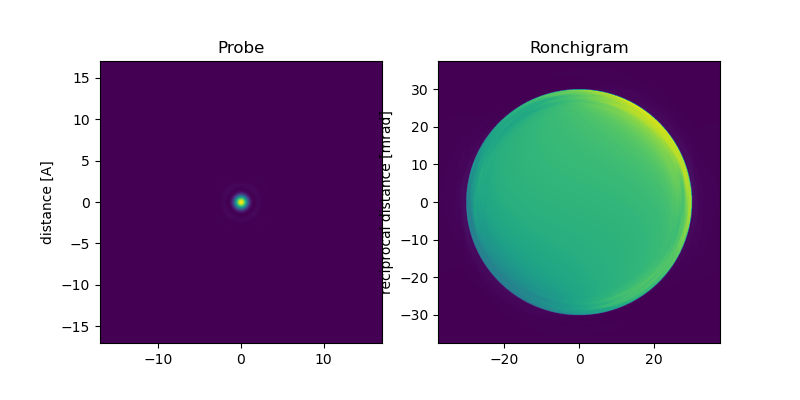

In [10]:
# -------- Input --------------
acceleration_voltage = 200*1000  # in eV
zero_C10 = True
zero_C12 = False
zero_C21 = True
zero_C23 = True
# ---------------------------------

if 'google.colab' in sys.modules:    
    from google.colab.output import eval_js
    
    clipboard = eval_js('''
    (async() => {
    const button = document.createElement('button');
    button.textContent = 'Read clipboard';
    document.body.appendChild(button);
    await new Promise((resolve) => {
      button.addEventListener('click', resolve);    
    });
    return await navigator.clipboard.readText();  
    })();
    ''')
else:
    from tkinter import Tk
    clipboard = Tk().clipboard_get()   


def pol2cart(value):
    polar = value.split('/')
    rho = float(polar[0].strip(' ')[:-2])
    phi = float(polar[1].strip(' ')[:-3])

    multiplier = 1.0
    if polar[0].strip(' ')[-2:] == 'um':
        multiplier = 1e3
    elif polar[0].strip(' ')[-2:] == 'pm':
        mulitplier = 1e-3
    elif polar[0].strip(' ')[-2:] == 'mm':
         mulitplier = 1e-6
    elif polar[0].strip(' ')[-2:] == 'm':
         mulitplier = 1e-9
         

    x = rho * np.cos(phi) * multiplier
    y = rho * np.sin(phi) * multiplier
    return(x, y)


def aberrations_from_text(clipboard):
    aberrations = {'C10':0,'C12a':0,'C12b':0,'C21a':0,'C21b':0,'C23a':0,'C23b':0,'C30':0.,
                      'C32a':0.,'C32b':-0.,'C34a':0.,'C34b':0.,'C41a':0.,'C41b':-0.,'C43a':0.,
                      'C43b':-0.,'C45a':-0.,'C45b':-0.,'C50':0.,'C52a':-0.,'C52b':0.,
                      'C54a':-0.,'C54b':-0.,'C56a':-0.,'C56b':0., 'C70': 0.}
    aberrations['acceleration_voltage'] = 200000
    
    lines = clipboard.split('\n')
    for line in lines:
        values = line.replace('\t','').replace("(",':').split(':')
        if values[0].strip(' ') == 'C1':
            aberrations['C10'] = float(values[1].strip(' ')[:-2])
        elif values[0].strip(' ') == 'A1':
            print(values[1])
            x, y = pol2cart(values[1])
            aberrations['C12a'] = x
            aberrations['C12b'] = y
        elif values[0].strip(' ') == 'B2':
            x, y = pol2cart(values[1])
            aberrations['C21a'] = 3*x 
            aberrations['C21b'] = 3*y
        elif values[0].strip(' ') == 'A2':
            x, y = pol2cart(values[1])
            aberrations['C23a'] = x 
            aberrations['C23b'] = y
        elif values[0].strip(' ') == 'C3':
            aberrations['C30'] = float(values[1].strip(' ')[:-2])
        elif values[0].strip(' ') == 'S3':
           
            x, y = pol2cart(values[1])
            aberrations['C32a'] = 4*x
            aberrations['C32b'] = 4*y
        elif values[0].strip(' ') == 'A3':
            x, y = pol2cart(values[1])
            aberrations['C34a'] = x 
            aberrations['C34b'] = y
        elif values[0].strip(' ') == 'B4':
            x, y = pol2cart(values[1])
            aberrations['C41a'] = 4*x 
            aberrations['C41b'] = 4*y
        elif values[0].strip(' ') == 'D4':
            x, y = pol2cart(values[1])
            aberrations['C43a'] = 4*x
            aberrations['C43b'] = 4*y
        elif values[0].strip(' ') == 'A4':
            x, y = pol2cart(values[1])
            aberrations['C45a'] = x 
            aberrations['C45b'] = y
        elif values[0].strip(' ') == 'C5':
            aberrations['C50'] = float(values[1].strip(' ')[:-2])
        elif values[0].strip(' ') == 'A5':
            x, y = pol2cart(values[1])
            aberrations['C56a'] = x 
            aberrations['C56b'] = y
    return aberrations
        
ab = aberrations_from_text(clipboard)
ab['acceleration_voltage'] = acceleration_voltage
if zero_C10:
    ab['C10'] = -0
if zero_C12:
    ab['C12a'] = 0
    ab['C12b'] = 0
if zero_C21:
    ab['C21a'] = 0
    ab['C21b'] = 0
if zero_C23:
    ab['C23a'] = 0
    ab['C23b'] = 0
ab['C12a'] = -0
ab['FOV'] =  1.120829747574103
ab['Cc'] = 1
pyTEMlib.probe_tools.print_aberrations(ab)
sizeX = sizeY = 1024
condensor_aperture_radius = ab['convergence_angle'] = 30
probe, A_k, chi  = pyTEMlib.probe_tools.get_probe( ab, sizeX, sizeY,  scale = 'mrad', verbose= True)

ronchi_FOV = 150 #mrad
ab['FOV'] = 4/ronchi_FOV*sizeX/2 * ab['wavelength'] *1000  #in nm
ab['convergence_angle'] = 30 ## let have a little bit of a view
print(ab['FOV'])
ronchigram = pyTEMlib.probe_tools.get_ronchigram(sizeX, ab, scale = 'mrad'  )

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(probe, extent = [-int(ab['FOV']/2),int(ab['FOV']/2),-int(ab['FOV']/2),int(ab['FOV']/2)])
ax[0].set_ylabel('distance [A]')
ax[0].set_title('Probe')
ax[1].imshow(ronchigram, extent = ab['ronchi_extent'])
ax[1].set_ylabel(ab['ronchi_label'])
ax[1].set_title('Ronchigram')


In [11]:
ab

{'C10': 0,
 'C12a': 0,
 'C12b': 0,
 'C21a': 0,
 'C21b': 0,
 'C23a': 0,
 'C23b': 0,
 'C30': 0.0,
 'C32a': 0.0,
 'C32b': -0.0,
 'C34a': 0.0,
 'C34b': 0.0,
 'C41a': 0.0,
 'C41b': -0.0,
 'C43a': 0.0,
 'C43b': -0.0,
 'C45a': -0.0,
 'C45b': -0.0,
 'C50': 0.0,
 'C52a': -0.0,
 'C52b': 0.0,
 'C54a': -0.0,
 'C54b': -0.0,
 'C56a': -0.0,
 'C56b': 0.0,
 'C70': 0.0,
 'acceleration_voltage': 200000,
 'FOV': 34.24165947565709,
 'Cc': 1,
 'convergence_angle': 30,
 'wavelength': 0.0025079340436272276,
 'C01a': 0.0,
 'C01b': 0.0,
 'chi': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'ronchi_extent': [-37.49999999999999,
  37.49999999999999,
  -37.49999999999999,
  37.49999999999999],
 'ronchi_label': 'reciprocal distance [mrad]'}

0.03


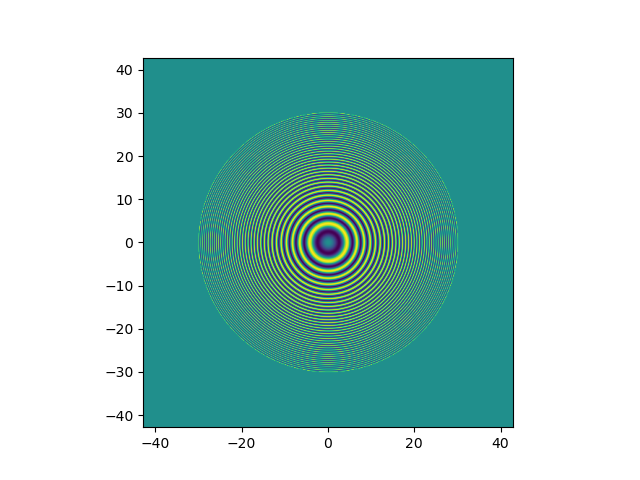

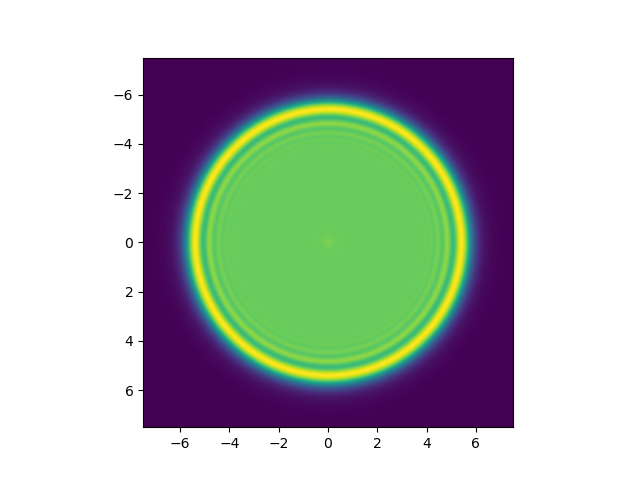

In [12]:
import scipy
sizeX = 512
ab['FOV'] = 15
ab['C10'] = 200
ab['C12b'] = -0
ab['C21a'] = -0


chi, A_k  = pyTEMlib.probe_tools.get_chi( ab, sizeX, sizeX, verbose= False)
    
chiT = np.vectorize(complex)(np.cos(chi), -np.sin(chi)) 
## Aply aperture function

chiT = chiT*A_k
# chiT = scipy.ndimage.gaussian_filter(chiT, 80)
## inverse fft of aberration function
i2  = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift (chiT)))
## intensity
probe = np.real(i2 * np.conjugate(i2))
ex = np.arcsin(sizeX/2/ab['FOV']/(1/ab['wavelength']))*1000

plt.figure()
plt.imshow(chiT.imag, extent=[-ex,ex,-ex,ex])

i2  = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift (chiT)))
## intensity
probe = np.real(i2 * np.conjugate(i2))
probe = scipy.ndimage.gaussian_filter(probe, .1/ab['FOV']*sizeX)
plt.figure()
plt.imshow(probe, extent=[-ab['FOV']/2, ab['FOV']/2,ab['FOV']/2,-ab['FOV']/2])

In [13]:
sizeX/ab['FOV']*.5

17.066666666666666

In [14]:
plt.close('all')

In [15]:
np.arcsin(4096/2/80/(1/ab['wavelength']))*1000


64.24730149539442

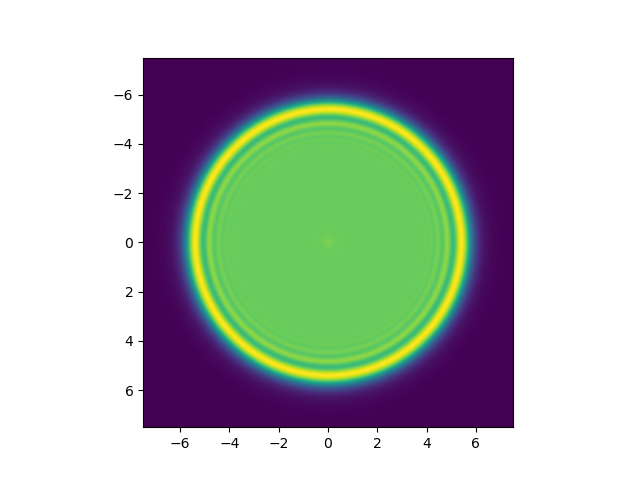

In [16]:
i2  = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift (chiT)))
## intensity
probe = np.real(i2 * np.conjugate(i2))
probe = scipy.ndimage.gaussian_filter(probe, .1/ab['FOV']*sizeX)
plt.figure()
plt.imshow(probe, extent=[-ab['FOV']/2, ab['FOV']/2,ab['FOV']/2,-ab['FOV']/2])


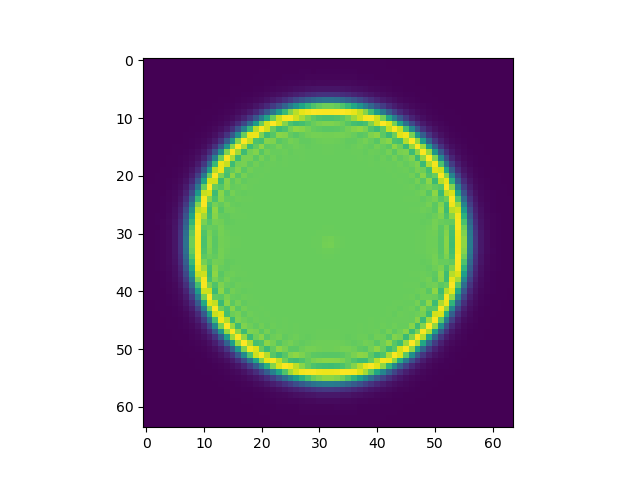

In [17]:
res = scipy.ndimage.zoom(probe, 1/8)
plt.figure()
plt.imshow(res)

In [18]:
sizeX = sizeY = 512

probe, A_k, chi  = pyTEMlib.probe_tools.get_probe( ab, sizeX, sizeY,  scale = 'mrad', verbose= True)

ronchi_FOV = 150 #mrad
ab['FOV'] = 10 #in Angstrom
ab['convergence_angle'] = 30 ## let have a little bit of a view
    
ronchigram = pyTEMlib.probe_tools.get_ronchigram(1024, ab, scale = 'mrad'  )

0.03
0.03


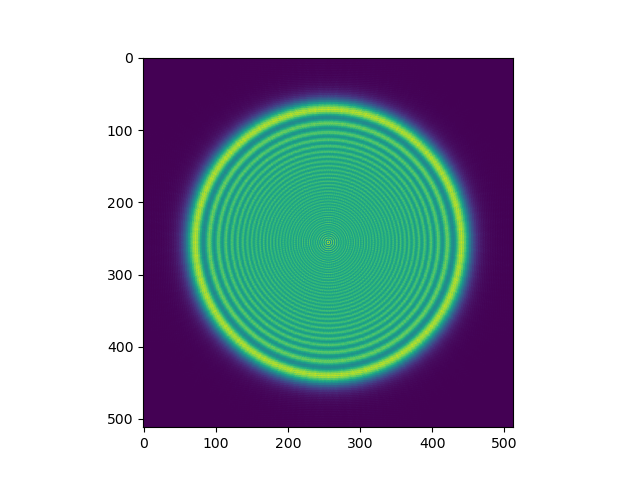

In [19]:
plt.figure()
plt.imshow(probe)
pyTEMlib.probe_tools.print_aberrations(ab)

In [20]:
chi, A_k  = pyTEMlib.probe_tools.get_chi( ab, sizeX, sizeY, verbose= False)
    

0.03


Text(0.5, 1.0, 'Ronchigram')

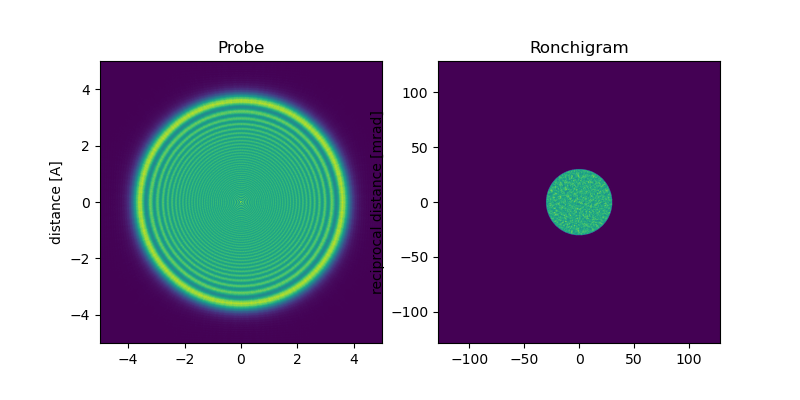

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(probe, extent = [-int(ab['FOV']/2),int(ab['FOV']/2),-int(ab['FOV']/2),int(ab['FOV']/2)])
ax[0].set_ylabel('distance [A]')
ax[0].set_title('Probe')
ax[1].imshow(ronchigram, extent = ab['ronchi_extent'])
ax[1].set_ylabel(ab['ronchi_label'])
ax[1].set_title('Ronchigram')

0.03


Text(0, 0.5, 'distance [nm]')

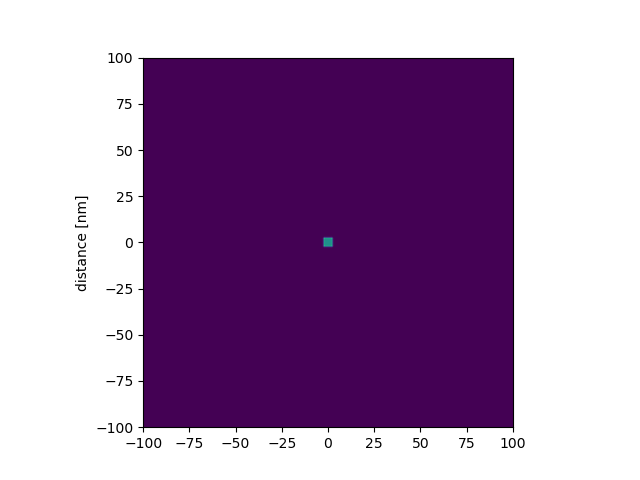

In [22]:

sizeX = sizeY =512*4

if False:
    ab['C10'] = 60
if True:
    ab['C12a'] = 0
    ab['C12b'] = 0
if True:
    ab['C21a'] = 0
    ab['C21b'] = 0
if True:
    ab['C23a'] = 0
    ab['C23b'] = 0

ab['FOV'] = 200
ab['Cc'] = 1
pyTEMlib.probe_tools.print_aberrations(ab)

condensor_aperture_radius = ab['convergence_angle'] = 30
probe, A_k, chi  = pyTEMlib.probe_tools.get_probe( ab, sizeX, sizeY,  scale = '1/nm', verbose= True)
plt.figure()
plt.imshow(probe, extent = [-int(ab['FOV']/2),int(ab['FOV']/2),-int(ab['FOV']/2),int(ab['FOV']/2)])
plt.gca().set_ylabel('distance [nm]')

In [23]:
from ase import build 
slab = build.fcc100('Al', size=(2, 2, 2), orthogonal=True)
from ase.visualize import view

view(slab, view='x3d')

<Popen: returncode: None args: ['C:\\Users\\gduscher\\AppData\\Local\\anacon...>

In [24]:
slab.positions

array([[1.43189123, 1.43189123, 0.        ],
       [4.2956737 , 1.43189123, 0.        ],
       [1.43189123, 4.2956737 , 0.        ],
       [4.2956737 , 4.2956737 , 0.        ],
       [0.        , 0.        , 2.025     ],
       [2.86378246, 0.        , 2.025     ],
       [0.        , 2.86378246, 2.025     ],
       [2.86378246, 2.86378246, 2.025     ]])

FOV: 70


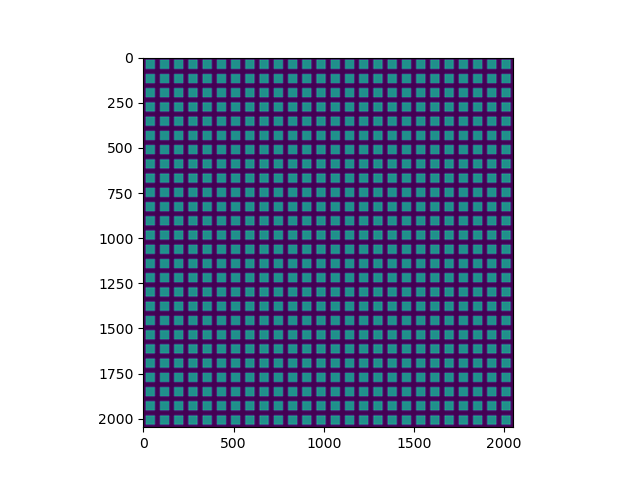

In [25]:
from ase import build 
ab['FOV'] = 7
FOV = ab['FOV']*10
ab['C10']  = 0
print('FOV:', FOV)
slab = build.fcc100('Al', size=(2, 2, 1), orthogonal=True)
slab *= (int(FOV/slab.cell[0,0]+1), int(FOV/slab.cell[1,1]+1), 1)
slab.center()
slab.positions, slab.cell[0,0]
ab['FOV'] = slab.cell[0,0]
pos = np.int32(slab.positions[:, :2]/ab['FOV']*sizeX)

img = np.zeros([sizeX,sizeX])
img[pos[:,0],pos[:,1]] = 13**2
import scipy
img2 = scipy.signal.fftconvolve(img, probe, mode='same')
img2.shape
plt.figure()
plt.imshow(img2)

In [26]:



pos

array([[  39,   39],
       [ 118,   39],
       [  39,  118],
       ...,
       [2008, 1929],
       [1929, 2008],
       [2008, 2008]])

   ## References



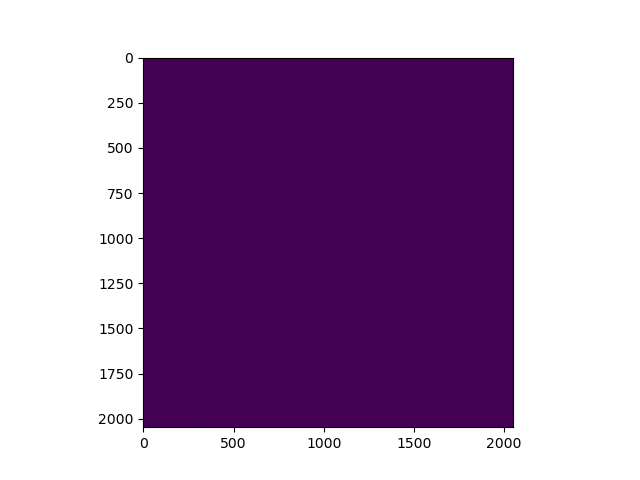

In [27]:
img = np.zeros([sizeX,sizeX])
img[pos[:,0],pos[:,1]] = 13**2

plt.figure()
plt.imshow(img)

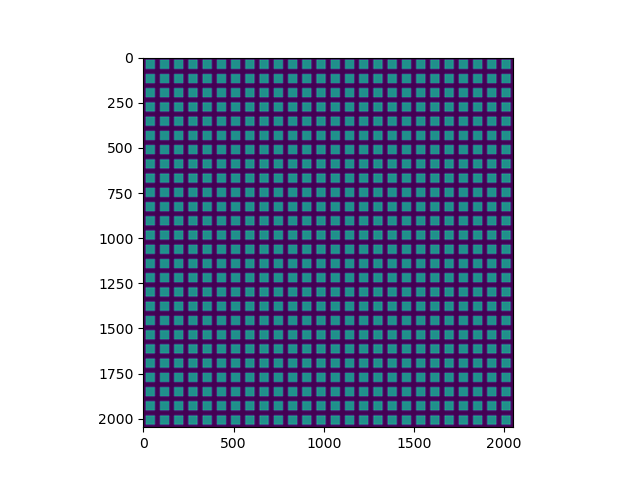

In [28]:
import scipy
img2 = scipy.signal.fftconvolve(img, probe, mode='same')
img2.shape
plt.figure()
plt.imshow(img2)

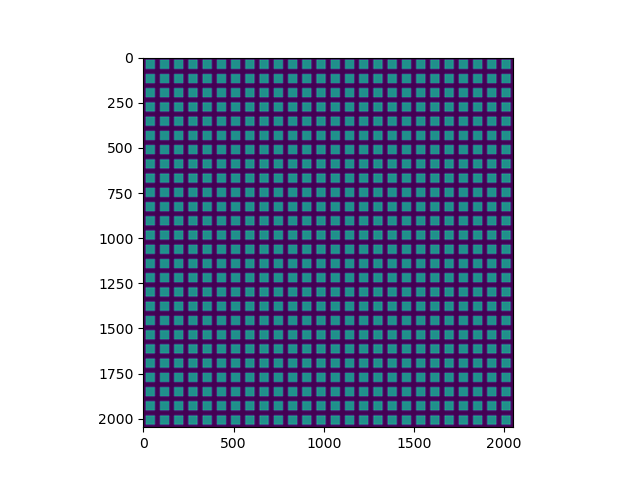

In [29]:
plt.figure()
plt.imshow(img2)


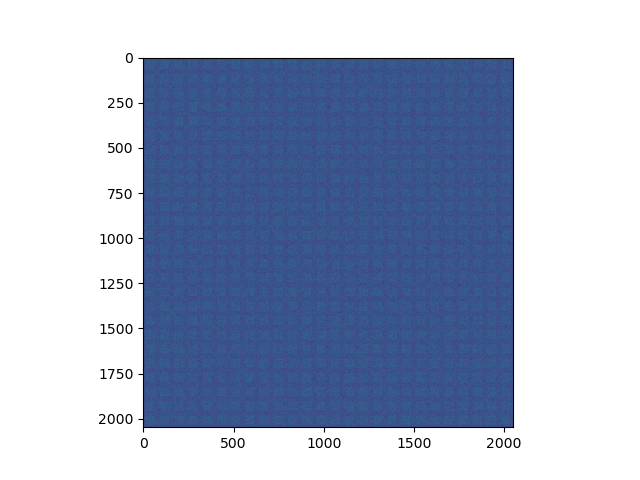

In [30]:
img2*= 10
noise = np.random.poisson(img2)
plt.figure()
plt.imshow(img2*noise+np.random.random(img2.shape)*noise.max())


In [31]:
from skimage.draw import random_shapes

def get_large_image(number_of_electrons=1000):
    image, _ = random_shapes((512, 512), min_shapes=15, max_shapes=26, shape='circle',
                             min_size=40, max_size = 60, allow_overlap=False, num_channels=1)
    image = 1-np.squeeze(image)/image.max()
    image[image<.1] = 0
    image[image>0] = number_of_electrons
    noise = np.random.poisson(image)
    image = image+noise+np.random.random(image.shape)*noise.max()
    return image
    

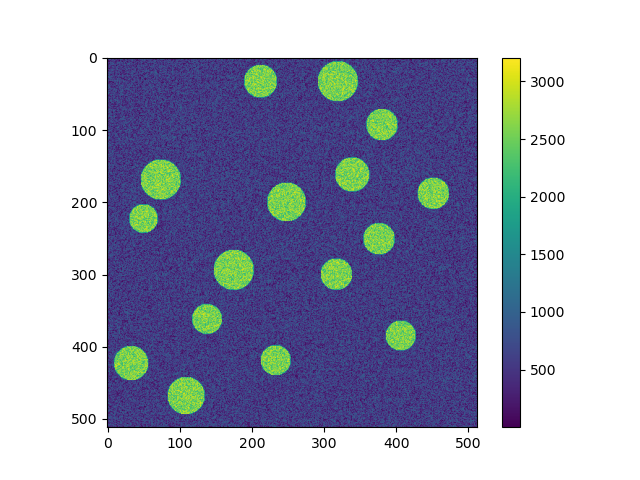

In [32]:
image = get_large_image()

plt.figure()
plt.imshow(image)
plt.colorbar()

0.03
0.03
0.03


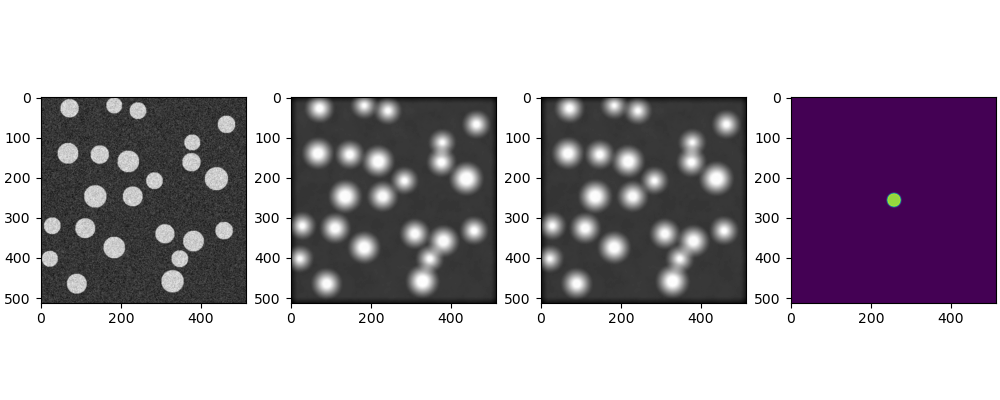

In [38]:
import skimage
import scipy

sizeX = 512
ab['FOV'] = 15
ab['C10'] = 2
ab['C12b'] = -0
ab['C21a'] = -0
ab['C23b'] = -159
ab['C21a'] = -30


def get_probe(ab):
        sizeX = 512*2
        ab['FOV'] = 20
        chi, A_k  = pyTEMlib.probe_tools.get_chi( ab, sizeX, sizeX, verbose= False)
        
        chiT = np.vectorize(complex)(np.cos(chi), -np.sin(chi)) 
        ## Aply aperture function
        
        chiT = chiT*A_k
        ## inverse fft of aberration function
        i2  = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift (chiT)))
        ## intensity
        probe = np.real(i2 * np.conjugate(i2))
        probe = scipy.ndimage.gaussian_filter(probe, 3)

        probe*=1000
        res = np.zeros((512, 512))
        res[256-32:256+32, 256-32:256+32 ] = skimage.transform.resize(probe, (64, 64))
        return res



def get_probe2(ab):    
    ab['FOV'] = 20
    probe, A_k, chi  = pyTEMlib.probe_tools.get_probe( ab, sizeX, sizeX,  scale = 'mrad', verbose= True)
    res = np.zeros((512, 512))
    res[256-32:256+32, 256-32:256+32 ] = skimage.transform.resize(probe, (64, 64))
    return probe
    
from skimage.draw import random_shapes

def get_large_image(number_of_electrons=1000):
    image, _ = random_shapes((512, 512), min_shapes=15, max_shapes=26, shape='circle',
                             min_size=40, max_size = 60, allow_overlap=False, num_channels=1)
    image = 1-np.squeeze(image)/image.max()
    image[image<.1] = 0
    image[image>0] = number_of_electrons
    noise = np.random.poisson(image)
    image = image+noise+np.random.random(image.shape)*noise.max()
    return image
     

def large_image (ab, image=None, FOV=15*4) :
    
    out = np.zeros([3, image.shape[0], image.shape[1]])

    C10 = ab['C10'] 
    res = get_probe(ab)
    out[0] = scipy.signal.fftconvolve(image, res, mode='same') 
    
    ab['C10'] = C10-180
    res = get_probe(ab)
    out[1] = scipy.signal.fftconvolve(image, res, mode='same') 

    ab['C10'] = C10+180
    res = get_probe(ab)
    out[2] = scipy.signal.fftconvolve(image, res, mode='same') 

    ab['C10'] = C10
    
    return out, res
ab['C10'] = 3
ab['C23b'] = -0

ab['C21a'] = -00
ab['C21b'] = -00

image = get_large_image(number_of_electrons=100)

imaged, res = large_image(ab, image, 90)
image *= 1000/image.max()

fig, axs = plt.subplots(1, 4, layout='constrained', figsize=(10, 4))

axs[0].imshow(imaged[0], cmap='gray')
axs[1].imshow(imaged[1], cmap='gray')
axs[2].imshow(imaged[2], cmap='gray')
axs[3].imshow(res)
#axs[3].set_xlim(256-30, 256+30)
#axs[3].set_ylim(256-30, 256+30)

C:\Users\gduscher\AppData\Local\Temp\ipykernel_10204\851367505.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  dec[0] = np.fft.ifft2(g1*(im2/im1).T)
C:\Users\gduscher\AppData\Local\Temp\ipykernel_10204\851367505.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  dec[1] = np.fft.ifft2(g1*(im3/im1).T)


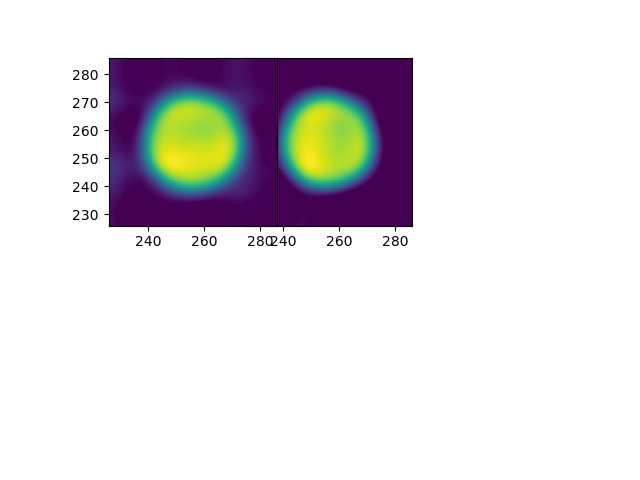

In [36]:
from pyTEMlib import probe_tools
def get_probe_shape_from_images(images):
    im1 = np.fft.fft2(np.array(images[0]))
    im2 = np.fft.fft2(np.array(images[1]))
    im3 = np.fft.fft2(np.array(images[2]))
    g1 = np.fft.fft2(probe_tools.make_gauss(512,512,3))

    dec = np.zeros([2, im1.shape[0], im1.shape[1]])
    dec[0] = np.fft.ifft2(g1*(im2/im1).T)
    dec[1] = np.fft.ifft2(g1*(im3/im1).T)

    return dec

dec = get_probe_shape_from_images(imaged)
plt.figure()
plt.subplot(211)
plt.imshow(dec[0].real.T, vmin = dec.real.max()/8)
plt.ylim(256-30,256+30)
plt.xlim(256-30,256+30)
plt.subplot(221)
plt.imshow(dec[1].real, vmin = 0)# dec.real.max()/8)
plt.ylim(256-30,256+30)
plt.xlim(256-30,256+30)



pyTEMlib.probe_tools.print_aberrations(ab)

0.03


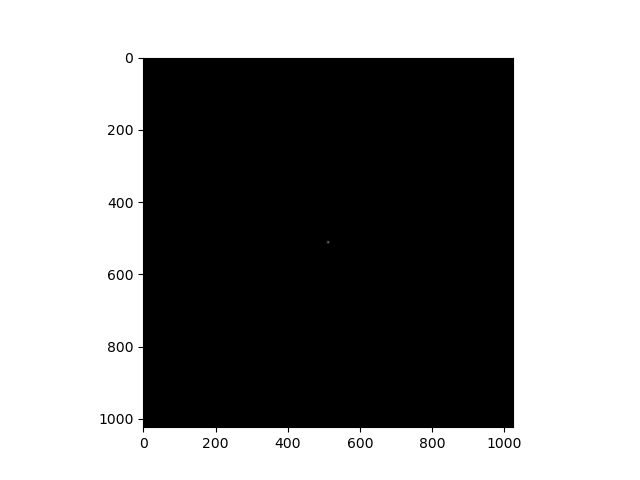

In [37]:
def get_probe(ab):    
    ab['FOV'] = 20
    sizeX = 512*2
    probe, A_k, chi  = pyTEMlib.probe_tools.get_probe( ab, sizeX, sizeX,  scale = 'mrad', verbose= True)
    
    res = np.zeros((512, 512))
    res[256-32:256+32, 256-32:256+32 ] = skimage.transform.resize(probe, (64, 64))
    return probe

pyTEMlib.probe_tools.print_aberrations(ab)
probe = get_probe(ab)

plt.figure()
plt.imshow(probe, cmap='gray')

In [87]:
ab['C50'] = -550
ab

{'C10': 3,
 'C12a': 0,
 'C12b': 0,
 'C21a': 0,
 'C21b': 0,
 'C23a': 11.667578600494137,
 'C23b': -60,
 'C30': 123,
 'C32a': 95.3047364258614,
 'C32b': -189.72105710231244,
 'C34a': -47.45099594807912,
 'C34b': -94.67424667529909,
 'C41a': -905.31842572806,
 'C41b': 9810.316128853203,
 'C43a': 4021.8433526960034,
 'C43b': 131.72716642732158,
 'C45a': -4702.390968272048,
 'C45b': -208.25028574642903,
 'C50': -550,
 'C52a': -0.0,
 'C52b': 0.0,
 'C54a': -0.0,
 'C54b': -0.0,
 'C56a': -36663.643489934424,
 'C56b': 21356.079837905396,
 'acceleration_voltage': 200000,
 'FOV': 2,
 'Cc': 1,
 'convergence_angle': 300,
 'wavelength': 0.0025079340450548005,
 'reciprocal_FOV': 0.15,
 'extent': [-150.0, 150.0, -150.0, 150.0],
 'size': 512,
 'C01a': 0.0,
 'C01b': 0.0,
 'chi': array([[42447.92563489, 42219.67612054, 41992.73711082, ...,
         52627.36411924, 52913.09493998, 53200.30223473],
        [42195.00438484, 41967.54619907, 41741.39624058, ...,
         52331.2204266 , 52615.87740101, 52902.0

In [170]:
pyTEMlib.probe_tools.print_aberrations(ab)

0.3


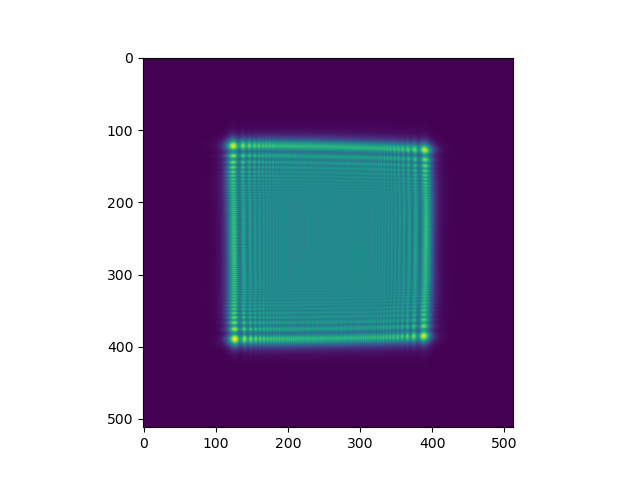

In [72]:
plt.figure()
ab['C10'] = -180
plt.imshow(get_probe(ab))

In [124]:
image[1].shape

(512,)

In [108]:
15*512/32

240.0

(512, 512)

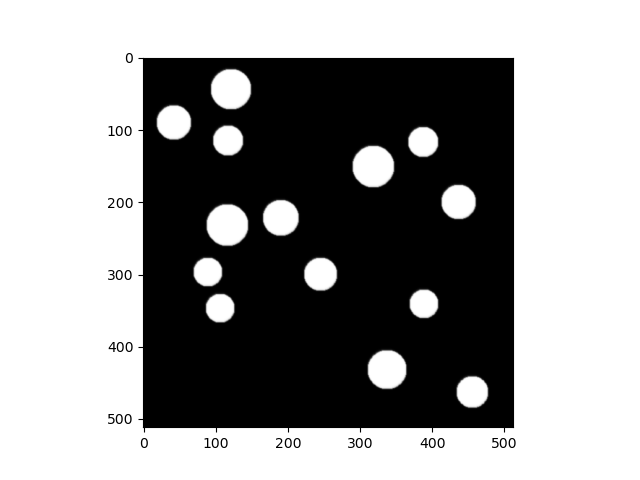

In [111]:
from skimage.draw import random_shapes

image, _ = random_shapes((512, 512), min_shapes=15, max_shapes=26, shape='circle',
                         min_size=40, max_size = 60, allow_overlap=False, num_channels=1)

image = 1-image[:,:,0]/image.max()
image[image<.1] = 0
image[image>0] = 1

img2 = scipy.signal.fftconvolve(image, res, mode='same') 
plt.figure()
plt.imshow(img2, cmap='gray')
image.shape

802607.1682143363

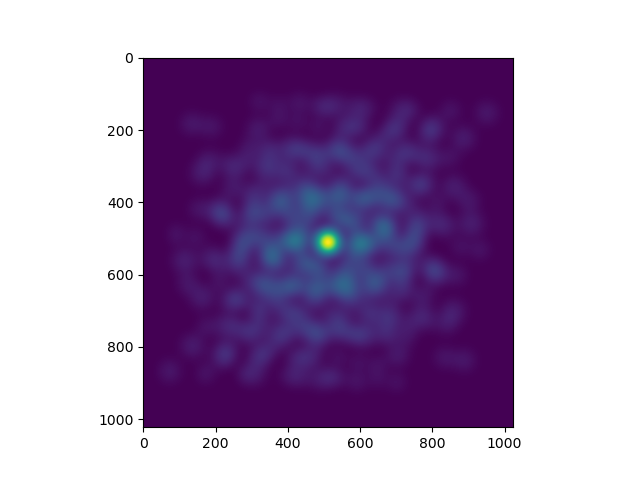

In [371]:
p =scipy.signal.correlate(imaged[1], imaged[0])
plt.figure()
plt.imshow(p)
p.max()

In [ ]:
datasets2 = fileWidget.datasets

fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(10, 4))
axs[0].set_title('focus A2:650nm')
axs[0].imshow(datasets2['Channel_000'], cmap='gray')
axs[1].set_title('underfocus A2:650nm')
axs[1].imshow(datasets2['Channel_001'], cmap='gray')
axs[2].imshow(datasets2['Channel_002'], cmap='gray')
axs[2].set_title('overfocus A2:650nm')
